In [1]:
#  library import

In [2]:
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image
import torchvision
import random

# download image 

In [3]:
# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

# reading image

In [4]:
img =read_image("demo_data/small-vehicles1.jpeg")
print("type img : ",type(img))
print("shape img : ",img.shape)

type img :  <class 'numpy.ndarray'>
shape img :  (580, 1068, 3)


# sahi prediction on faster_RCNN and retina_net Model 

In [5]:
faster_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
retina_model =torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

C:\Users\z004k7nr\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\z004k7nr\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\z004k7nr\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also us

In [6]:
# sahi model declearation for prediction

faster_detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    model=faster_model,
    confidence_threshold=0.3, # threshold 
    image_size=640,
    device="cpu", # or "cuda:0"   # cpu if gpu available (torch.cuda.is_available() -> true)
    load_at_init=True,
)
retina_detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    model=retina_model,
    confidence_threshold=0.5, 
    image_size=640,
    device="cpu", # or "cuda:0"
    load_at_init=True,
)


# sahi prediction 

In [7]:
# slice_height,slice_width  - it is used create slices of the image and for each slices it predict bbox.

faster_result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    faster_detection_model,
    slice_height = 320,  
    slice_width = 320,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)
retina_result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    retina_detection_model,
    slice_height = 320,
    slice_width = 320,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 12 number of slices.


C:\Users\z004k7nr\Anaconda3\envs\torch\lib\site-packages\sahi\utils\torch.py:28: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  img = torch.from_numpy(img).float()


Performing prediction on 12 number of slices.


# converting annotation in coco format

In [8]:
faster_result_dict = faster_result.to_coco_annotations()
retina_result_dict = retina_result.to_coco_annotations()

In [9]:
faster_result_dict[0]

{'image_id': None,
 'bbox': [319, 317, 64, 48],
 'score': 0.9990589022636414,
 'category_id': 3,
 'category_name': 'car',
 'segmentation': [],
 'iscrowd': 0,
 'area': 3072}

In [10]:
def extract_bbox_score_label(result_dict,image_size = (580, 1068),normalize=True):
    print("len of the result : ",len(result_dict))
    bbox_list,score_list,label_list,cat_name_list =[],[],[],[]
    for item in result_dict:
        bbox_list.append(item['bbox'])
        score_list.append(item['score'])
        label_list.append(item['category_id'])
        cat_name_list.append(item['category_name'])
    if normalize :
        normalize_bbox_list =[]
        for box in bbox_list:
            xmin = box[0]/image_size[1]
            ymin = box[1]/image_size[0]
            xmax = (box[0]+box[2])/image_size[1]
            ymax = (box[1]+box[3])/image_size[0]
            normalize_bbox_list.append([xmin,ymin,xmax,ymax])
        return normalize_bbox_list,score_list,label_list,cat_name_list

    return bbox_list,score_list,label_list,cat_name_lis

In [11]:
faster_bbox_list,faster_score_list,faster_label_list,faster_cat_name_list = extract_bbox_score_label(faster_result_dict,normalize=True)
print("faster_bbox_list : ",faster_bbox_list)
print("faster_score_list : ",faster_score_list)
print("faster_label_list : ",faster_label_list)
print("faster_cat_name_list : ",faster_cat_name_list)

len of the result :  40
faster_bbox_list :  [[0.29868913857677903, 0.5465517241379311, 0.3586142322097378, 0.6293103448275862], [0.41947565543071164, 0.5258620689655172, 0.46348314606741575, 0.593103448275862], [0.7134831460674157, 0.43448275862068964, 0.7434456928838952, 0.4896551724137931], [0.35767790262172283, 0.47413793103448276, 0.39232209737827717, 0.5258620689655172], [0.7780898876404494, 0.5310344827586206, 0.8174157303370787, 0.5913793103448276], [0.5056179775280899, 0.38448275862068965, 0.5449438202247191, 0.44655172413793104], [0.6704119850187266, 0.41724137931034483, 0.700374531835206, 0.4706896551724138], [0.4859550561797753, 0.3810344827586207, 0.5159176029962547, 0.42931034482758623], [0.6966292134831461, 0.29482758620689653, 0.7031835205992509, 0.30517241379310345], [0.6554307116104869, 0.40344827586206894, 0.6769662921348315, 0.44482758620689655], [0.7116104868913857, 0.39827586206896554, 0.7303370786516854, 0.42758620689655175], [0.7350187265917603, 0.355172413793103

In [12]:
retina_bbox_list,retina_score_list,retina_label_list,retina_cat_name_list = extract_bbox_score_label(retina_result_dict)
print("retina_bbox_list : ",retina_bbox_list)
print("retina_score_list : ",retina_score_list)
print("retina_label_list : ",retina_label_list)
print("retina_cat_name_list : ",retina_cat_name_list)

len of the result :  26
retina_bbox_list :  [[0.41853932584269665, 0.5293103448275862, 0.46441947565543074, 0.5896551724137931], [0.300561797752809, 0.553448275862069, 0.3586142322097378, 0.6275862068965518], [0.35767790262172283, 0.4793103448275862, 0.3913857677902622, 0.5241379310344828], [0.7162921348314607, 0.4482758620689655, 0.7425093632958801, 0.4896551724137931], [0.6638576779026217, 0.4086206896551724, 0.7153558052434457, 0.47413793103448276], [0.7106741573033708, 0.39827586206896554, 0.7303370786516854, 0.42758620689655175], [0.7790262172284644, 0.5310344827586206, 0.8183520599250936, 0.593103448275862], [0.49250936329588013, 0.3896551724137931, 0.5514981273408239, 0.453448275862069], [0.4897003745318352, 0.3879310344827586, 0.5102996254681648, 0.41551724137931034], [0.5271535580524345, 0.4068965517241379, 0.5711610486891385, 0.45517241379310347], [0.7350187265917603, 0.35344827586206895, 0.7490636704119851, 0.3775862068965517], [0.5571161048689138, 0.4, 0.6020599250936329, 0

# WBF 

In [13]:
# !pip install ensemble-boxes 

In [14]:
weights = [2, 1]  # weight to model output ex-   [faster_RCNN_bbox, retina_net_bbox] -> [2,1]

iou_thr = 0.5 
skip_box_thr = 0.0001
sigma = 0.1

# boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
# boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
# boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
# boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

# applying WBF

In [15]:
from ensemble_boxes import *
boxes_list=[faster_bbox_list,retina_bbox_list]
scores_list =[faster_score_list,retina_score_list]
labels_list=[faster_label_list,retina_label_list]

boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [16]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import torch

def visualize_images(img_list,rows=2, cols=2):
    """
    It is used to plot/visualize the batch of image used in loader while training
    Args:
        img_batch (list): list of image in (C,H,W) having pixel value [0,1] 
                            eg :- torh.ToTensor(img)
        target_batch (list): list of target dict which have bbox, label,category name etc infomation  
        rows (int): no of rows to plot images eg -(batch_size=4, rows=2,cols=2 or rows=4,cols=1)
        cols (int): no of columns to plot images 

    Returns: plot the images.

    """
    _, axs = plt.subplots( rows, cols,figsize=(20, 10))
    axs = axs.flatten()
    i=0
    font = r"D:\work\neom\ngeca-watercontamination-service\fonts\SiemensSans_Global_Roman.ttf" 
    for img,box in zip(img_list,boxes):
        img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = torch.tensor(img)
#         img = draw_bounding_boxes(img,box,colors = "yellow",font_size=500,width=2)
#         img =img.permute(1, 2, 0)
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title("Image_"+str(i))
        i+=1
    plt.show()

In [17]:
import cv2
import numpy as np
from ensemble_boxes import *

def show_image(img, name='image'):
#     cv2_imshow(im.astype(np.uint8))
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, img)
    cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
# def show_image(img):
#     cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
#     cv2.imshow('Image', img)
#     cv2.waitKey(1)
    

def gen_color_list(model_num, labels_num):
    color_list = np.zeros((model_num, labels_num, 3))
    colors_to_use = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (0, 0, 0)]
    total = 0
    for i in range(model_num):
        for j in range(labels_num):
            color_list[i, j, :] = colors_to_use[total]
            total = (total + 1) % len(colors_to_use)
    return color_list

def get_denormalize_box(boxes_list, img_size):
    x1 = int(img_size[1] * boxes_list[0])
    y1 = int(img_size[0] * boxes_list[1])
    x2 = int(img_size[1] * boxes_list[2])
    y2 = int(img_size[0] * boxes_list[3])
    return x1,y1,x2,y2

        
def draw_bounding_box(img,boxes,labels=None,scores=None,color=(255,255,255),thickness = 1,text_color=(255,200,150)):
    if not isinstance(boxes[0],list):
#         print("making list :")
        boxes =[boxes]
        if scores != None:
            scores=[scores]
        if labels != None:
            labels =[labels]

    for i, box in enumerate(boxes):
#         print(box)
        x1,y1,x2,y2 = get_denormalize_box(box, (img.shape)[0:2])
        cv2.rectangle(img,(x1,y1), (x2,y2),color, thickness)
        if (labels != None and scores != None):
            cv2.putText(img, str(labels[i])+":"+str(scores[i]), (x1, y1 - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.7,text_color, thickness)
        if labels !=None:
            cv2.putText(img, str(labels[i]), (x1, y1 - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.7,text_color, thickness)
    return img

def show_boxes(image,boxes_list, scores_list, labels_list, image_size=(580, 1068),thickness = 2,mereg_show=True):
    colors_to_use = [(0, 0, 255), (0, 255, 0), (255, 255, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (0, 0, 0)]
    for i in range(len(boxes_list)):
        color = colors_to_use[i]
        for j in range(len(boxes_list[i])):
            x1,y1,x2,y2 = get_denormalize_box(boxes_list[i][j],image_size)
            lbl = labels_list[i][j]
            cv2.rectangle(image, (x1, y1), (x2, y2), color, int(thickness * scores_list[i][j]))
#     show_image(image)
    return image

# reading image

In [18]:
img = read_image("demo_data/small-vehicles1.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("type img : ",type(img))
print("shape img : ",img.shape)

type img :  <class 'numpy.ndarray'>
shape img :  (580, 1068, 3)


# drawing bounding boxes on image

In [19]:
faster_img =draw_bounding_box(img.copy(), faster_bbox_list,thickness = 1,color=(0,0,255))
retina_img =draw_bounding_box(img.copy(), retina_bbox_list,thickness = 1,color=(0, 255, 0))
faster_retina_img = show_boxes(img.copy(),boxes_list, scores_list, labels_list)
wbf_out_img = draw_bounding_box(img.copy(), boxes.tolist(),thickness = 1)

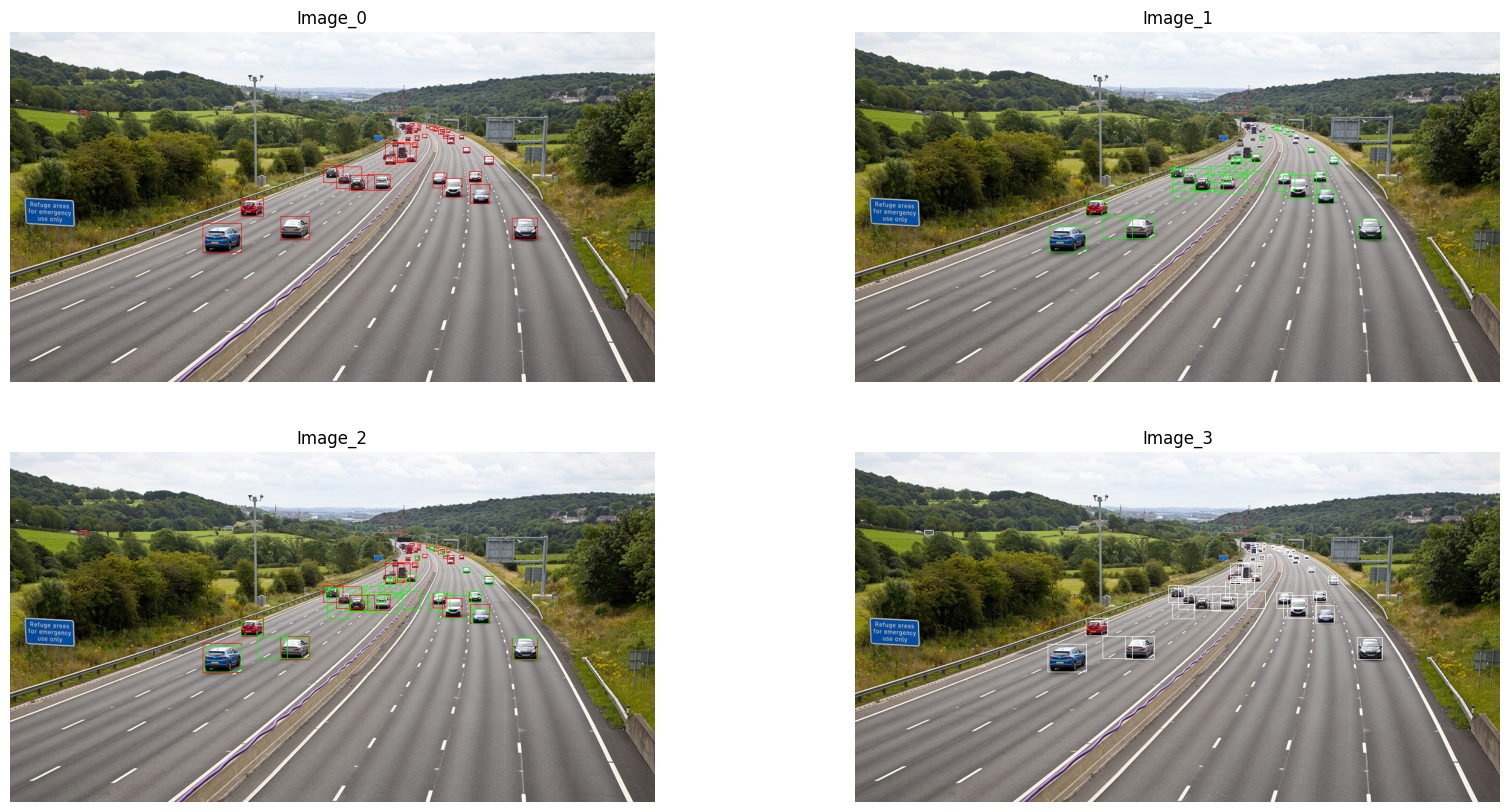

In [20]:
visualize_images([faster_img,retina_img,faster_retina_img,wbf_out_img])

In [21]:
show_image(faster_img,"faster_RCNN")

In [22]:
show_image(retina_img,"retina_RCNN")

In [ ]:
show_image(faster_retina_img,"combined_model")

In [ ]:
show_image(wbf_out_img,"WBF_output")